In [1]:
import h5py
import os
import cv2
import tensorflow.keras as tfk
import random
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import *
from keras.models import *
from keras.layers import *

In [2]:
def noise_supression_block(ip, numFilt= 64):
  convN1= Conv2D(numFilt, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
 # bnNS1= BatchNormalization()(convN1)
  convN2= Conv2D(numFilt, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(convN1)
#  bnNS2= BatchNormalization()(convN2)
  convNout= Multiply()([convN1,convN2])
  return convNout

In [3]:
inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
bn1= BatchNormalization()(conv1)
#drop1= Dropout(0.5)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
NAblock1 = noise_supression_block(bn1, 64)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
bn2= BatchNormalization()(conv2)
#drop2= Dropout(0.5)(conv2)
NAblock2 = noise_supression_block(bn2, 128)
pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#drop3= Dropout(0.5)(conv3)
bn3= BatchNormalization()(conv3)
NAblock3 = noise_supression_block(bn3, 256)
pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#drop4= Dropout(0.5)(conv4)
bn4= BatchNormalization()(conv4)
NAblock4 = noise_supression_block(bn4, 512)
pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#drop5 = Dropout(0.2)(conv5)
bn5= BatchNormalization()(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn5))
merge6 = concatenate([NAblock4,up6], axis= 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
bn6= BatchNormalization()(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn6))
merge7 = concatenate( [NAblock3,up7], axis=3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
bn7 = BatchNormalization()(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn7))
merge8 = concatenate( [NAblock2,up8], axis= 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
bn8= BatchNormalization()(conv8)


up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn8))
merge9 = concatenate( [NAblock1,up9], axis= 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

bn9= BatchNormalization() (conv9)

conv10 = Conv2D(1, 1, activation = 'sigmoid')(bn9)

model = Model(inputs = inputs, outputs = conv10)

In [6]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
LR= 0.0001
optim = tfk.optimizers.Adam(LR)
loss= tfk.losses.binary_crossentropy

metrics=[tfk.metrics.MeanIoU(num_classes=2)]

model.compile(optim,loss, metrics)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [8]:
DATA_DIR = '/content/drive/MyDrive/skin data'

In [9]:
x_train_dir = os.path.join(DATA_DIR, 'train', 'Images')
y_train_dir = os.path.join(DATA_DIR, 'train', 'mask')

x_valid_dir = os.path.join(DATA_DIR, 'valid', 'Images')
y_valid_dir = os.path.join(DATA_DIR, 'valid', 'mask')

x_test_dir = os.path.join(DATA_DIR, 'test','Images')
y_test_dir = os.path.join(DATA_DIR, 'test', 'mask')

In [10]:
from tqdm import tqdm
img_size= (256,256)
idt= sorted(os.listdir(x_train_dir))
idmt = sorted(os.listdir(y_train_dir))

XTrain = np.zeros((len(idt),) + img_size + (3,), dtype=np.float32)
YTrain = np.zeros((len(idmt),) + img_size + (1,), dtype=np.uint8)

for i in tqdm(range(len(idt))):
  image= cv2.imread(os.path.join(x_train_dir,idt[i]))
  image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = (image - image.min()) / (image.max() - image.min())
  image= cv2.resize(image,(256,256) )
  XTrain[i]= image

for i in tqdm(range(len(idmt))):
  mask= cv2.imread(os.path.join(y_train_dir,idmt[i]))
  mask= mask/255
  mask= cv2.resize(mask,(256,256) )
  YTrain[i]= np.expand_dims(mask[:,:,1],axis=-1)

100%|██████████| 700/700 [04:18<00:00,  2.71it/s]


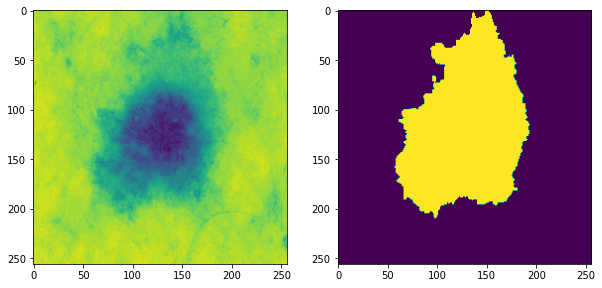

209


In [11]:
i= np.random.randint(len(XTrain))
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(np.squeeze(XTrain[i,:,:,2]))
f.add_subplot(1,2, 2)
plt.imshow(np.squeeze(YTrain[i]))
plt.show()
print(i)

In [12]:
idv= sorted(os.listdir(x_valid_dir))
idmv= sorted(os.listdir(y_valid_dir))

XValid = np.zeros((len(idv),) + img_size + (3,), dtype=np.float32)
YValid = np.zeros((len(idmv),) + img_size + (1,), dtype=np.uint8)

for i in tqdm(range(len(idv))):
  image= cv2.imread(os.path.join(x_valid_dir,idv[i]))
  image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = (image - image.min()) / (image.max() - image.min())
  image=cv2.resize(image,img_size)
  XValid[i]= image

for i in tqdm(range(len(idmv))):
  mask= cv2.imread(os.path.join(y_valid_dir,idmv[i]))
  mask = mask/255
  mask= cv2.resize(mask,img_size)
  YValid[i]= np.expand_dims(mask[:,:,1], axis= -1)

100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


In [13]:
id= sorted(os.listdir(x_test_dir))
idm= sorted(os.listdir(y_test_dir))

XTest = np.zeros((len(id),) + img_size + (3,), dtype=np.float32)
YTest = np.zeros((len(idm),) + img_size + (1,), dtype=np.uint8)

for i in tqdm(range(len(id))):
  image= cv2.imread(os.path.join(x_test_dir,id[i]))
  image= cv2.resize(image,img_size)
  image = (image - image.min()) / (image.max() - image.min())
  #image= image[56:184,56:184]
  XTest[i]= image


for i in tqdm(range(len(idm))):
  mask= cv2.imread(os.path.join(y_test_dir,idm[i]))
  mask= cv2.resize(mask, img_size)
  mask = mask/255
  #mask= mask[56:184,56:184]
  YTest[i]= np.expand_dims(mask[:,:,0], axis= -1)

100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


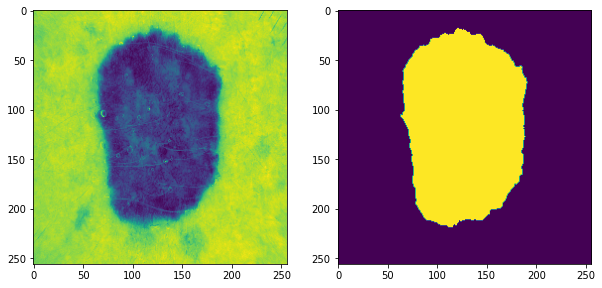

In [14]:
i= np.random.randint(len(XTest))
f, axis= plt.subplots(1,2, figsize=(10,10))
axis[0].imshow(np.squeeze(XTest[i,:,:,1]))
axis[1].imshow(np.squeeze(YTest[i,:,:,0]))

In [18]:
# train model
callback= [tfk.callbacks.ReduceLROnPlateau(patience= 15, verbose= 2, monitor= 'val_loss')]
history = model.fit(XTrain,YTrain,epochs= 100, batch_size= 4, validation_data= (XValid,YValid), shuffle= True)

Epoch 1/100
175/175 [==============================] - 75s 415ms/step - loss: 0.4033 - mean_io_u_1: 0.3656 - val_loss: 0.6367 - val_mean_io_u_1: 0.3518
Epoch 2/100
175/175 [==============================] - 72s 410ms/step - loss: 0.3034 - mean_io_u_1: 0.3635 - val_loss: 0.3056 - val_mean_io_u_1: 0.3518
Epoch 3/100
175/175 [==============================] - 72s 409ms/step - loss: 0.2466 - mean_io_u_1: 0.3649 - val_loss: 0.2276 - val_mean_io_u_1: 0.3518
Epoch 4/100
175/175 [==============================] - 71s 407ms/step - loss: 0.2292 - mean_io_u_1: 0.3698 - val_loss: 0.2460 - val_mean_io_u_1: 0.3518
Epoch 5/100
175/175 [==============================] - 71s 407ms/step - loss: 0.2189 - mean_io_u_1: 0.3658 - val_loss: 0.2268 - val_mean_io_u_1: 0.3521
Epoch 6/100
175/175 [==============================] - 71s 408ms/step - loss: 0.2012 - mean_io_u_1: 0.3687 - val_loss: 0.2877 - val_mean_io_u_1: 0.3749
Epoch 7/100
175/175 [==============================] - 71s 408ms/step - loss: 0.1998 - m

In [19]:
test= model.predict(XTest, verbose=1)
pred= (test>0.5).astype(np.uint8)

4/4 [==============================] - 6s 482ms/step


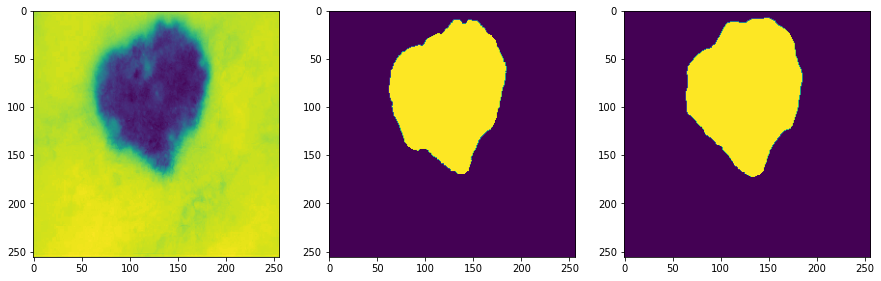

In [28]:
i= np.random.randint(len(XTest))
f, axis= plt.subplots(1,3, figsize=(15,15))
axis[0].imshow(np.squeeze(XTest[i,:,:,1]))
axis[1].imshow(np.squeeze(YTest[i,:,:,0]))
axis[2].imshow(np.squeeze(pred[i,:,:,0]))